In [1]:
# Import / install relevant Python packages
import numpy as np
import pandas as pd  
import math
import MCF_INV

In [2]:
trading_results_columns_names = ['KMeans_L_S','KMeans_L_transactions','KMeans_S_transactions',
                                'DBSCAN_L_S','DBSCAN_L_transactions','DBSCAN_S_transactions',
                                'Agg_L_S','Agg_L_transactions','Agg_S_transactions']
start_date = 19800131
end_date = 20201231

In [3]:
df_preprocessing_done = pd.read_csv('D:/USB Drive/Data/DachengXiu/df_preprocessing_done.csv')
df_KMeans = pd.read_csv('D:/USB Drive/Data/DachengXiu/df_KMeans.csv')
df_DBSCAN = pd.read_csv('D:/USB Drive/Data/DachengXiu/df_DBSCAN.csv')
df_Agglomerative = pd.read_csv('D:/USB Drive/Data/DachengXiu/df_Agglomerative.csv')

In [4]:
#set -1 outliers
df_KMeans['cluster k=500'].values[df_KMeans['outlier k=500'] == 1 ] = -1 #set -1 as outlier

In [5]:
#Preparing all data for trading in one table
df_data_for_trading = df_preprocessing_done[["DATE","permno","mom1m"]]
df_data_for_trading.rename(columns = {'mom1m':'rt-1',}, inplace = True)
df_data_for_trading["rt"] = df_data_for_trading.sort_values(['permno','DATE']).shift(-1)["rt-1"]
df_data_for_trading["KMeans_cluster"] = df_KMeans[["DATE","permno","cluster k=500"]].sort_values(['permno','DATE']).shift(1)["cluster k=500"]
df_data_for_trading["DBSCAN_cluster"] = df_DBSCAN[["DATE","permno","cluster alpha=10"]].sort_values(['permno','DATE']).shift(1)["cluster alpha=10"]
df_data_for_trading["Agglomerative_cluster"] = df_Agglomerative[["DATE","permno","cluster alpha=30"]].sort_values(['permno','DATE']).shift(1)["cluster alpha=30"]
#droping 2 rows with NaN
df_data_for_trading=df_data_for_trading.dropna()
df_data_for_trading = df_data_for_trading[(df_data_for_trading['DATE'] >= start_date) & (df_data_for_trading['DATE'] <= end_date)] #Dates 19800131 - 20201231


C:\Users\vlada\AppData\Local\Temp\ipykernel_15608\4183108130.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_for_trading.rename(columns = {'mom1m':'rt-1',}, inplace = True)
C:\Users\vlada\AppData\Local\Temp\ipykernel_15608\4183108130.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_for_trading["rt"] = df_data_for_trading.sort_values(['permno','DATE']).shift(-1)["rt-1"]
C:\Users\vlada\AppData\Local\Temp\ipykernel_15608\4183108130.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [6]:
def summary_stats_extended(r, n=252,com=False, rf=0.03):
    """Return a DataFrame that contains aggregated summary stats for the returns in the columns of r. Parameters are:
    - r: data set of returns
    - n: optional, number of periods within a year
    - com: optional, deterimines whether expected returns are calculated as annualized sample mean or annualized compunded return
    - rf: optional, determines risk-free rate"""
    return pd.DataFrame({"Annualized Return": MCF_INV.expRet(r,n,com),
                        "Annualized Vol": MCF_INV.annualize_vol(r,n),
                        "Sharpe Ratio": MCF_INV.sharpe(r,n,rf,com),
                        "Downside deviation": MCF_INV.semidev(r,n,zeromean=False).min()[0],#workaround to get single value
                        "Sortino ratio": MCF_INV.sortino(r,n,rf,com).min(),#workaround to get single value
                        "Max Drawdown": r.aggregate(lambda r: MCF_INV.drawdown(r).Drawdowns.min()),
                        "Skewness": r.skew(),
                        "Kurtosis": r.kurt(),
                        "Cornish-Fisher VaR (5%)": MCF_INV.VaR(r,a=0.05).loc['Cornish Fisher'],
                        "Historic CVaR (5%)": MCF_INV.cvar_historic(r)
                        })


In [7]:
#inicilize df - make empty df
#initial dataframe
df_trading_results=pd.DataFrame(columns=['DATE','permno','rt-1','rt','KMeans_cluster','DBSCAN_cluster','Agglomerative_cluster', 'KMeans_L_S','KMeans_L_transactions','KMeans_S_transactions'])
dates = sorted(df_data_for_trading['DATE'].unique())
previous_long_list = []
previous_short_list = []
welth_ukupan = 1
for date in dates:
    print("DATE ",date)
    #date = 19800131

    df_data_for_trading_window = df_data_for_trading[df_data_for_trading['DATE'] == date]
    #add columns for trading results
    df_data_for_trading_window=df_data_for_trading_window.reindex(columns=df_data_for_trading_window.columns.tolist()+['KMeans_L_S','KMeans_L_transactions','KMeans_S_transactions'])
    #determing paies to calculate std     
    KMeans_unique_clusters_for_date = df_data_for_trading_window['KMeans_cluster'].unique()
    pairs_return_substraction_list = []
    
    for unique_cluster in KMeans_unique_clusters_for_date:
        #list of all rt-1 for cluster        
        rt_1_rt_permno_numpy_for_cluster = df_data_for_trading_window[df_data_for_trading_window['KMeans_cluster'] == unique_cluster][["rt-1","rt","permno"]].sort_values(["rt-1"],ascending=False).to_numpy()
        #print("len(rt_1_rt_permno_numpy_for_cluster) ",len(rt_1_rt_permno_numpy_for_cluster))
        #If it is not outlier ( -1 ) and 
        #if difference first and last is bigger than 0 means that there is not only one element
        if ( (unique_cluster > -1 )  & (len(rt_1_rt_permno_numpy_for_cluster) > 1)):
            # calculating pairs
            for pair in range (0, math.floor(len(rt_1_rt_permno_numpy_for_cluster)/2)):
            #pair for trading found
                pairs_return_substraction_list.append(rt_1_rt_permno_numpy_for_cluster[pair][0] - rt_1_rt_permno_numpy_for_cluster[len(rt_1_rt_permno_numpy_for_cluster)-1-pair][0])
    #fill long and short positions
    std_dev_of_rt_1 = np.std(pairs_return_substraction_list)
    #print("std_dev_of_rt_1 ",std_dev_of_rt_1)
    #determing paires     
    long_list = []
    short_list = []
    return_for_date = 0

    #KMeans_unique_clusters_for_date = df_data_for_trading_window['KMeans_cluster'].unique()
    for unique_cluster in KMeans_unique_clusters_for_date:
        #list of all rt-1 for cluster
        rt_1_rt_permno_numpy_for_cluster = df_data_for_trading_window[df_data_for_trading_window['KMeans_cluster'] == unique_cluster][["rt-1","rt","permno"]].sort_values(["rt-1"],ascending=False).to_numpy()
        #If it is not outlier ( -1 ) and 
        #if difference first and last is bigger than 1 cross sectional standard dev then we calculate pairs for trading
        #at the same time I will filter all outliers with 1 point in cluster
        if ( (unique_cluster > -1 )  & ((rt_1_rt_permno_numpy_for_cluster[0][0] - rt_1_rt_permno_numpy_for_cluster[-1][0]) > std_dev_of_rt_1)):
            # calculating pairs
            for pair in range (0, math.floor(len(rt_1_rt_permno_numpy_for_cluster)/2)):
                #If difference for pairs lefted to be checked is less than std than brake for loop
                #print("pair ", pair, " len(rt_1_rt_permno_numpy_for_cluster)-1-pair ", len(rt_1_rt_permno_numpy_for_cluster)-1-pair)
                if ((rt_1_rt_permno_numpy_for_cluster[pair][0] - rt_1_rt_permno_numpy_for_cluster[len(rt_1_rt_permno_numpy_for_cluster)-1-pair][0]) <= std_dev_of_rt_1):
                    break
            #pair for trading found
                long_list.append(rt_1_rt_permno_numpy_for_cluster[len(rt_1_rt_permno_numpy_for_cluster)-1-pair][2])
                short_list.append(rt_1_rt_permno_numpy_for_cluster[pair][2]) 
            #adding return for date
                return_for_date = return_for_date - rt_1_rt_permno_numpy_for_cluster[pair][1] + rt_1_rt_permno_numpy_for_cluster[len(rt_1_rt_permno_numpy_for_cluster)-1-pair][1]
    #print(" number of pairs ", len(long_list), " return_for_date ", return_for_date/(len(long_list)*2))
    #fill long and short positions
    df_data_for_trading_window['KMeans_L_S'].values[df_data_for_trading_window['permno'].isin(long_list)] = 1
    df_data_for_trading_window['KMeans_L_S'].values[df_data_for_trading_window['permno'].isin(short_list)] = -1
    #determen transactions - if company has to be in portfolio and is not in previous month porfolio
    #than it should be transaction
    difference_long_first = list(set(long_list) - set(previous_long_list))
    difference_short_first = list(set(short_list) - set(previous_short_list))
    
    df_data_for_trading_window['KMeans_L_transactions'].values[df_data_for_trading_window['permno'].isin(difference_long_first)] = 1
    df_data_for_trading_window['KMeans_S_transactions'].values[df_data_for_trading_window['permno'].isin(difference_short_first)] = 1
    
    #We also need to close previous mont portfolio difference
    difference_long_second = list(set(previous_long_list) - set(long_list))
    difference_short_second = list(set(previous_short_list) - set(short_list))
    #adding companies from closed postions not existing in current month in order to keep record of transactions.
    list_for_adding_companies = list(set(difference_long_second + difference_short_second) - set(df_data_for_trading_window['permno'].tolist()))
    df_additional_companies = pd.DataFrame(list_for_adding_companies, columns = ['permno'])
    df_data_for_trading_window=pd.concat([df_data_for_trading_window,df_additional_companies],axis=0)
    df_data_for_trading_window['DATE'] =  df_data_for_trading_window['DATE'].fillna(date)

    
    df_data_for_trading_window['KMeans_L_transactions'].values[df_data_for_trading_window['permno'].isin(difference_long_second)] = -1
    df_data_for_trading_window['KMeans_S_transactions'].values[df_data_for_trading_window['permno'].isin(difference_short_second)] = -1
    previous_long_list = long_list
    previous_short_list = short_list

    df_trading_results=pd.concat([df_trading_results,df_data_for_trading_window],axis=0)
    #welth_ukupan = welth_ukupan*(1+return_for_date/(len(long_list)*2) - 0.001*len(difference_long_first+difference_short_first+difference_long_second+difference_short_second))
    #print("welth_ukupan= ",welth_ukupan)


DATE  19800131
DATE  19800229
DATE  19800331
DATE  19800430
DATE  19800530
DATE  19800630
DATE  19800731
DATE  19800829
DATE  19800930
DATE  19801031
DATE  19801128
DATE  19801231
DATE  19810130
DATE  19810227
DATE  19810331
DATE  19810430
DATE  19810529
DATE  19810630
DATE  19810731
DATE  19810831
DATE  19810930
DATE  19811030
DATE  19811130
DATE  19811231
DATE  19820129
DATE  19820226
DATE  19820331
DATE  19820430
DATE  19820528
DATE  19820630
DATE  19820730
DATE  19820831
DATE  19820930
DATE  19821029
DATE  19821130
DATE  19821231
DATE  19830131
DATE  19830228
DATE  19830331
DATE  19830429
DATE  19830531
DATE  19830630
DATE  19830729
DATE  19830831
DATE  19830930
DATE  19831031
DATE  19831130
DATE  19831230
DATE  19840131
DATE  19840229
DATE  19840330
DATE  19840430
DATE  19840531
DATE  19840629
DATE  19840731
DATE  19840831
DATE  19840928
DATE  19841031
DATE  19841130
DATE  19841231
DATE  19850131
DATE  19850228
DATE  19850329
DATE  19850430
DATE  19850531
DATE  19850628
DATE  1985

In [8]:
df_trading_results.to_csv('D:/USB Drive/Data/DachengXiu/KMeans_trading_results.csv')

In [9]:
#cumulative welth for KMeans
df_trading_results_sorted = df_trading_results.sort_values(['DATE','permno'])

df_trading_results_sorted['result'] = df_trading_results_sorted['rt']*df_trading_results_sorted['KMeans_L_S']

#df_trading_results_sorted['count'] =         df_trading_results_sorted.groupby('DATE')['KMeans_L_S'].count()

#df_trading_results_by_date = df_trading_results_sorted.groupby('DATE').count())
#df_trading_results_sorted.groupby('DATE')['KMeans_L_S'].count()
(1 + df_trading_results_sorted.groupby('DATE')['result'].sum()/df_trading_results_sorted.groupby('DATE')['KMeans_L_S'].count()).cumprod()

DATE
19800131.0     0.996946
19800229.0     1.003535
19800331.0     1.024543
19800430.0     1.042873
19800530.0     1.059618
                ...    
20200831.0    24.945058
20200930.0    24.721165
20201030.0    24.584415
20201130.0    24.898165
20201231.0    24.771051
Length: 492, dtype: float64

In [10]:
#inicilize df - make empty df
#initial dataframe
df_trading_results=pd.DataFrame(columns=['DATE','permno','rt-1','rt','KMeans_cluster','DBSCAN_cluster','Agglomerative_cluster', 'DBSCAN_L_S','DBSCAN_L_transactions','DBSCAN_S_transactions'])
dates = sorted(df_data_for_trading['DATE'].unique())
previous_long_list = []
previous_short_list = []
welth_ukupan = 1
for date in dates:
    print("DATE ",date)
    #date = 19800131

    df_data_for_trading_window = df_data_for_trading[df_data_for_trading['DATE'] == date]
    #add columns for trading results
    df_data_for_trading_window=df_data_for_trading_window.reindex(columns=df_data_for_trading_window.columns.tolist()+['DBSCAN_L_S','DBSCAN_L_transactions','DBSCAN_S_transactions'])
    #determing paies to calculate std     
    DBSCAN_unique_clusters_for_date = df_data_for_trading_window['DBSCAN_cluster'].unique()
    pairs_return_substraction_list = []
    
    for unique_cluster in DBSCAN_unique_clusters_for_date:
        #list of all rt-1 for cluster        
        rt_1_rt_permno_numpy_for_cluster = df_data_for_trading_window[df_data_for_trading_window['DBSCAN_cluster'] == unique_cluster][["rt-1","rt","permno"]].sort_values(["rt-1"],ascending=False).to_numpy()
        #print("len(rt_1_rt_permno_numpy_for_cluster) ",len(rt_1_rt_permno_numpy_for_cluster))
        #If it is not outlier ( -1 ) and 
        #if difference first and last is bigger than 0 means that there is not only one element
        if ( (unique_cluster > -1 )  & (len(rt_1_rt_permno_numpy_for_cluster) > 1)):
            # calculating pairs
            for pair in range (0, math.floor(len(rt_1_rt_permno_numpy_for_cluster)/2)):
            #pair for trading found
                pairs_return_substraction_list.append(rt_1_rt_permno_numpy_for_cluster[pair][0] - rt_1_rt_permno_numpy_for_cluster[len(rt_1_rt_permno_numpy_for_cluster)-1-pair][0])
    #fill long and short positions
    std_dev_of_rt_1 = np.std(pairs_return_substraction_list)
    #print("std_dev_of_rt_1 ",std_dev_of_rt_1)
    #determing paires     
    long_list = []
    short_list = []
    return_for_date = 0

    #DBSCAN_unique_clusters_for_date = df_data_for_trading_window['DBSCAN_cluster'].unique()
    for unique_cluster in DBSCAN_unique_clusters_for_date:
        #list of all rt-1 for cluster
        rt_1_rt_permno_numpy_for_cluster = df_data_for_trading_window[df_data_for_trading_window['DBSCAN_cluster'] == unique_cluster][["rt-1","rt","permno"]].sort_values(["rt-1"],ascending=False).to_numpy()
        #If it is not outlier ( -1 ) and 
        #if difference first and last is bigger than 1 cross sectional standard dev then we calculate pairs for trading
        #at the same time I will filter all outliers with 1 point in cluster
        if ( (unique_cluster > -1 )  & ((rt_1_rt_permno_numpy_for_cluster[0][0] - rt_1_rt_permno_numpy_for_cluster[-1][0]) > std_dev_of_rt_1)):
            # calculating pairs
            for pair in range (0, math.floor(len(rt_1_rt_permno_numpy_for_cluster)/2)):
                #If difference for pairs lefted to be checked is less than std than brake for loop
                #print("pair ", pair, " len(rt_1_rt_permno_numpy_for_cluster)-1-pair ", len(rt_1_rt_permno_numpy_for_cluster)-1-pair)
                if ((rt_1_rt_permno_numpy_for_cluster[pair][0] - rt_1_rt_permno_numpy_for_cluster[len(rt_1_rt_permno_numpy_for_cluster)-1-pair][0]) <= std_dev_of_rt_1):
                    break
            #pair for trading found
                long_list.append(rt_1_rt_permno_numpy_for_cluster[len(rt_1_rt_permno_numpy_for_cluster)-1-pair][2])
                short_list.append(rt_1_rt_permno_numpy_for_cluster[pair][2]) 
            #adding return for date
                return_for_date = return_for_date - rt_1_rt_permno_numpy_for_cluster[pair][1] + rt_1_rt_permno_numpy_for_cluster[len(rt_1_rt_permno_numpy_for_cluster)-1-pair][1]
    #print(" number of pairs ", len(long_list), " return_for_date ", return_for_date/(len(long_list)*2))
    #fill long and short positions
    df_data_for_trading_window['DBSCAN_L_S'].values[df_data_for_trading_window['permno'].isin(long_list)] = 1
    df_data_for_trading_window['DBSCAN_L_S'].values[df_data_for_trading_window['permno'].isin(short_list)] = -1
    #determen transactions - if company has to be in portfolio and is not in previous month porfolio
    #than it should be transaction
    difference_long_first = list(set(long_list) - set(previous_long_list))
    difference_short_first = list(set(short_list) - set(previous_short_list))
    
    df_data_for_trading_window['DBSCAN_L_transactions'].values[df_data_for_trading_window['permno'].isin(difference_long_first)] = 1
    df_data_for_trading_window['DBSCAN_S_transactions'].values[df_data_for_trading_window['permno'].isin(difference_short_first)] = 1
    
    #We also need to close previous mont portfolio difference
    difference_long_second = list(set(previous_long_list) - set(long_list))
    difference_short_second = list(set(previous_short_list) - set(short_list))
    #adding companies from closed postions not existing in current month in order to keep record of transactions.
    list_for_adding_companies = list(set(difference_long_second + difference_short_second) - set(df_data_for_trading_window['permno'].tolist()))
    df_additional_companies = pd.DataFrame(list_for_adding_companies, columns = ['permno'])
    df_data_for_trading_window=pd.concat([df_data_for_trading_window,df_additional_companies],axis=0)
    df_data_for_trading_window['DATE'] =  df_data_for_trading_window['DATE'].fillna(date)

    
    df_data_for_trading_window['DBSCAN_L_transactions'].values[df_data_for_trading_window['permno'].isin(difference_long_second)] = -1
    df_data_for_trading_window['DBSCAN_S_transactions'].values[df_data_for_trading_window['permno'].isin(difference_short_second)] = -1
    previous_long_list = long_list
    previous_short_list = short_list

    df_trading_results=pd.concat([df_trading_results,df_data_for_trading_window],axis=0)
    #welth_ukupan = welth_ukupan*(1+return_for_date/(len(long_list)*2) - 0.001*len(difference_long_first+difference_short_first+difference_long_second+difference_short_second))
    #print("welth_ukupan= ",welth_ukupan)


DATE  19800131
DATE  19800229
DATE  19800331
DATE  19800430
DATE  19800530
DATE  19800630
DATE  19800731
DATE  19800829
DATE  19800930
DATE  19801031
DATE  19801128
DATE  19801231
DATE  19810130
DATE  19810227
DATE  19810331
DATE  19810430
DATE  19810529
DATE  19810630
DATE  19810731
DATE  19810831
DATE  19810930
DATE  19811030
DATE  19811130
DATE  19811231
DATE  19820129
DATE  19820226
DATE  19820331
DATE  19820430
DATE  19820528
DATE  19820630
DATE  19820730
DATE  19820831
DATE  19820930
DATE  19821029
DATE  19821130
DATE  19821231
DATE  19830131
DATE  19830228
DATE  19830331
DATE  19830429
DATE  19830531
DATE  19830630
DATE  19830729
DATE  19830831
DATE  19830930
DATE  19831031
DATE  19831130
DATE  19831230
DATE  19840131
DATE  19840229
DATE  19840330
DATE  19840430
DATE  19840531
DATE  19840629
DATE  19840731
DATE  19840831
DATE  19840928
DATE  19841031
DATE  19841130
DATE  19841231
DATE  19850131
DATE  19850228
DATE  19850329
DATE  19850430
DATE  19850531
DATE  19850628
DATE  1985

In [11]:
df_trading_results.to_csv('D:/USB Drive/Data/DachengXiu/DBSCAN_trading_results.csv')

In [12]:
#cumulative welth for DBSCAN
df_trading_results_sorted = df_trading_results.sort_values(['DATE','permno'])

df_trading_results_sorted['result'] = df_trading_results_sorted['rt']*df_trading_results_sorted['DBSCAN_L_S']

(1 + df_trading_results_sorted.groupby('DATE')['result'].sum()/df_trading_results_sorted.groupby('DATE')['DBSCAN_L_S'].count()).cumprod()

DATE
19800131.0     0.977220
19800229.0     0.968109
19800331.0     1.015113
19800430.0     0.976466
19800530.0     0.998663
                ...    
20200831.0    18.199289
20200930.0    18.356591
20201030.0    18.711663
20201130.0    18.527924
20201231.0    18.359735
Length: 492, dtype: float64

In [13]:
#inicilize df - make empty df
#initial dataframe
df_trading_results=pd.DataFrame(columns=['DATE','permno','rt-1','rt','KMeans_cluster','DBSCAN_cluster','Agglomerative_cluster', 'Agglomerative_L_S','Agglomerative_L_transactions','Agglomerative_S_transactions'])
dates = sorted(df_data_for_trading['DATE'].unique())
previous_long_list = []
previous_short_list = []
welth_ukupan = 1
for date in dates:
    print("DATE ",date)
    #date = 19800131

    df_data_for_trading_window = df_data_for_trading[df_data_for_trading['DATE'] == date]
    #add columns for trading results
    df_data_for_trading_window=df_data_for_trading_window.reindex(columns=df_data_for_trading_window.columns.tolist()+['Agglomerative_L_S','Agglomerative_L_transactions','Agglomerative_S_transactions'])
    #determing paies to calculate std     
    Agglomerative_unique_clusters_for_date = df_data_for_trading_window['Agglomerative_cluster'].unique()
    pairs_return_substraction_list = []
    
    for unique_cluster in Agglomerative_unique_clusters_for_date:
        #list of all rt-1 for cluster        
        rt_1_rt_permno_numpy_for_cluster = df_data_for_trading_window[df_data_for_trading_window['Agglomerative_cluster'] == unique_cluster][["rt-1","rt","permno"]].sort_values(["rt-1"],ascending=False).to_numpy()
        #print("len(rt_1_rt_permno_numpy_for_cluster) ",len(rt_1_rt_permno_numpy_for_cluster))
        #If it is not outlier ( -1 ) and 
        #if difference first and last is bigger than 0 means that there is not only one element
        if ( (unique_cluster > -1 )  & (len(rt_1_rt_permno_numpy_for_cluster) > 1)):
            # calculating pairs
            for pair in range (0, math.floor(len(rt_1_rt_permno_numpy_for_cluster)/2)):
            #pair for trading found
                pairs_return_substraction_list.append(rt_1_rt_permno_numpy_for_cluster[pair][0] - rt_1_rt_permno_numpy_for_cluster[len(rt_1_rt_permno_numpy_for_cluster)-1-pair][0])
    #fill long and short positions
    std_dev_of_rt_1 = np.std(pairs_return_substraction_list)
    #print("std_dev_of_rt_1 ",std_dev_of_rt_1)
    #determing paires     
    long_list = []
    short_list = []
    return_for_date = 0

    #Agglomerative_unique_clusters_for_date = df_data_for_trading_window['Agglomerative_cluster'].unique()
    for unique_cluster in Agglomerative_unique_clusters_for_date:
        #list of all rt-1 for cluster
        rt_1_rt_permno_numpy_for_cluster = df_data_for_trading_window[df_data_for_trading_window['Agglomerative_cluster'] == unique_cluster][["rt-1","rt","permno"]].sort_values(["rt-1"],ascending=False).to_numpy()
        #If it is not outlier ( -1 ) and 
        #if difference first and last is bigger than 1 cross sectional standard dev then we calculate pairs for trading
        #at the same time I will filter all outliers with 1 point in cluster
        if ( (unique_cluster > -1 )  & ((rt_1_rt_permno_numpy_for_cluster[0][0] - rt_1_rt_permno_numpy_for_cluster[-1][0]) > std_dev_of_rt_1)):
            # calculating pairs
            for pair in range (0, math.floor(len(rt_1_rt_permno_numpy_for_cluster)/2)):
                #If difference for pairs lefted to be checked is less than std than brake for loop
                #print("pair ", pair, " len(rt_1_rt_permno_numpy_for_cluster)-1-pair ", len(rt_1_rt_permno_numpy_for_cluster)-1-pair)
                if ((rt_1_rt_permno_numpy_for_cluster[pair][0] - rt_1_rt_permno_numpy_for_cluster[len(rt_1_rt_permno_numpy_for_cluster)-1-pair][0]) <= std_dev_of_rt_1):
                    break
            #pair for trading found
                long_list.append(rt_1_rt_permno_numpy_for_cluster[len(rt_1_rt_permno_numpy_for_cluster)-1-pair][2])
                short_list.append(rt_1_rt_permno_numpy_for_cluster[pair][2]) 
            #adding return for date
                return_for_date = return_for_date - rt_1_rt_permno_numpy_for_cluster[pair][1] + rt_1_rt_permno_numpy_for_cluster[len(rt_1_rt_permno_numpy_for_cluster)-1-pair][1]
    #print(" number of pairs ", len(long_list), " return_for_date ", return_for_date/(len(long_list)*2))
    #fill long and short positions
    df_data_for_trading_window['Agglomerative_L_S'].values[df_data_for_trading_window['permno'].isin(long_list)] = 1
    df_data_for_trading_window['Agglomerative_L_S'].values[df_data_for_trading_window['permno'].isin(short_list)] = -1
    #determen transactions - if company has to be in portfolio and is not in previous month porfolio
    #than it should be transaction
    difference_long_first = list(set(long_list) - set(previous_long_list))
    difference_short_first = list(set(short_list) - set(previous_short_list))
    
    df_data_for_trading_window['Agglomerative_L_transactions'].values[df_data_for_trading_window['permno'].isin(difference_long_first)] = 1
    df_data_for_trading_window['Agglomerative_S_transactions'].values[df_data_for_trading_window['permno'].isin(difference_short_first)] = 1
    
    #We also need to close previous mont portfolio difference
    difference_long_second = list(set(previous_long_list) - set(long_list))
    difference_short_second = list(set(previous_short_list) - set(short_list))
    #adding companies from closed postions not existing in current month in order to keep record of transactions.
    list_for_adding_companies = list(set(difference_long_second + difference_short_second) - set(df_data_for_trading_window['permno'].tolist()))
    df_additional_companies = pd.DataFrame(list_for_adding_companies, columns = ['permno'])
    df_data_for_trading_window=pd.concat([df_data_for_trading_window,df_additional_companies],axis=0)
    df_data_for_trading_window['DATE'] =  df_data_for_trading_window['DATE'].fillna(date)

    
    df_data_for_trading_window['Agglomerative_L_transactions'].values[df_data_for_trading_window['permno'].isin(difference_long_second)] = -1
    df_data_for_trading_window['Agglomerative_S_transactions'].values[df_data_for_trading_window['permno'].isin(difference_short_second)] = -1
    previous_long_list = long_list
    previous_short_list = short_list

    df_trading_results=pd.concat([df_trading_results,df_data_for_trading_window],axis=0)
    #welth_ukupan = welth_ukupan*(1+return_for_date/(len(long_list)*2) - 0.001*len(difference_long_first+difference_short_first+difference_long_second+difference_short_second))
    #print("welth_ukupan= ",welth_ukupan)


DATE  19800131
DATE  19800229
DATE  19800331
DATE  19800430
DATE  19800530
DATE  19800630
DATE  19800731
DATE  19800829
DATE  19800930
DATE  19801031
DATE  19801128
DATE  19801231
DATE  19810130
DATE  19810227
DATE  19810331
DATE  19810430
DATE  19810529
DATE  19810630
DATE  19810731
DATE  19810831
DATE  19810930
DATE  19811030
DATE  19811130
DATE  19811231
DATE  19820129
DATE  19820226
DATE  19820331
DATE  19820430
DATE  19820528
DATE  19820630
DATE  19820730
DATE  19820831
DATE  19820930
DATE  19821029
DATE  19821130
DATE  19821231
DATE  19830131
DATE  19830228
DATE  19830331
DATE  19830429
DATE  19830531
DATE  19830630
DATE  19830729
DATE  19830831
DATE  19830930
DATE  19831031
DATE  19831130
DATE  19831230
DATE  19840131
DATE  19840229
DATE  19840330
DATE  19840430
DATE  19840531
DATE  19840629
DATE  19840731
DATE  19840831
DATE  19840928
DATE  19841031
DATE  19841130
DATE  19841231
DATE  19850131
DATE  19850228
DATE  19850329
DATE  19850430
DATE  19850531
DATE  19850628
DATE  1985

In [14]:
df_trading_results.to_csv('D:/USB Drive/Data/DachengXiu/Agglomerative_trading_results.csv')

In [15]:
#cumulative welth for Agglomerative
df_trading_results_sorted = df_trading_results.sort_values(['DATE','permno'])

df_trading_results_sorted['result'] = df_trading_results_sorted['rt']*df_trading_results_sorted['Agglomerative_L_S']

(1 + df_trading_results_sorted.groupby('DATE')['result'].sum()/df_trading_results_sorted.groupby('DATE')['Agglomerative_L_S'].count()).cumprod()

DATE
19800131.0     1.002698
19800229.0     0.998930
19800331.0     1.020090
19800430.0     1.027852
19800530.0     1.038737
                ...    
20200831.0    19.193209
20200930.0    19.189518
20201030.0    19.203505
20201130.0    19.391229
20201231.0    19.537671
Length: 492, dtype: float64

Analysis:

In [16]:
df_trading_results_KMeans = pd.read_csv('D:/USB Drive/Data/DachengXiu/KMeans_trading_results.csv')
df_trading_results_DBSCAN = pd.read_csv('D:/USB Drive/Data/DachengXiu/DBSCAN_trading_results.csv')
df_trading_results_Agglomerative = pd.read_csv('D:/USB Drive/Data/DachengXiu/Agglomerative_trading_results.csv')

<AxesSubplot: xlabel='DATE'>

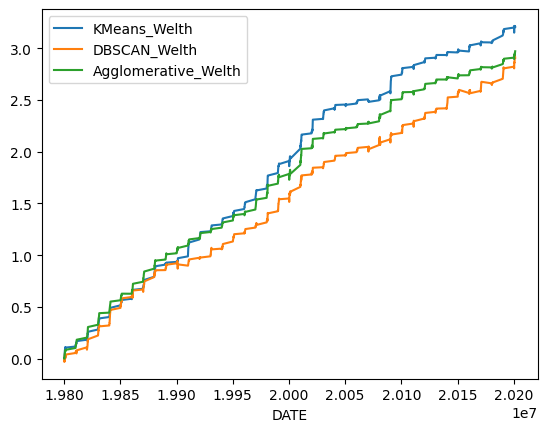

In [17]:
#Log Cumulative Welth Index 
#cumulative welth for KMeans
df_trading_results_KMeans_sorted = df_trading_results_KMeans.sort_values(['DATE','permno'])

df_trading_results_KMeans_sorted['result'] = df_trading_results_KMeans_sorted['rt']*df_trading_results_KMeans_sorted['KMeans_L_S']

df_log_welth = np.log((1 + df_trading_results_KMeans_sorted.groupby('DATE')['result'].sum()/df_trading_results_KMeans_sorted.groupby('DATE')['KMeans_L_S'].count()).cumprod())

#cumulative welth for DBSCAN
df_trading_results_DBSCAN_sorted = df_trading_results_DBSCAN.sort_values(['DATE','permno'])

df_trading_results_DBSCAN_sorted['result'] = df_trading_results_DBSCAN_sorted['rt']*df_trading_results_DBSCAN_sorted['DBSCAN_L_S']

df_log_welth = pd.concat([df_log_welth,np.log((1 + df_trading_results_DBSCAN_sorted.groupby('DATE')['result'].sum()/df_trading_results_DBSCAN_sorted.groupby('DATE')['DBSCAN_L_S'].count()).cumprod())],axis=1)

df_log_welth = df_log_welth.rename(columns={ df_log_welth.columns[0]: "KMeans_Welth",df_log_welth.columns[1]: "DBSCAN_Welth"})

#cumulative welth for Agglomerative
df_trading_results_Agglomerative_sorted = df_trading_results_Agglomerative.sort_values(['DATE','permno'])

df_trading_results_Agglomerative_sorted['result'] = df_trading_results_Agglomerative_sorted['rt']*df_trading_results_Agglomerative_sorted['Agglomerative_L_S']

df_log_welth = pd.concat([df_log_welth,np.log((1 + df_trading_results_Agglomerative_sorted.groupby('DATE')['result'].sum()/df_trading_results_Agglomerative_sorted.groupby('DATE')['Agglomerative_L_S'].count()).cumprod())],axis=1)

df_log_welth = df_log_welth.rename(columns={ df_log_welth.columns[2]: "Agglomerative_Welth" })
df_log_welth.plot()

My results are different from paper.

In [18]:
#Summary annualized statistic for KMeans
df_trading_results_KMeans_sorted = df_trading_results_KMeans.sort_values(['DATE','permno'])

df_trading_results_KMeans_sorted['result'] = df_trading_results_KMeans_sorted['rt']*df_trading_results_KMeans_sorted['KMeans_L_S']

df_KMeans_portfolio_ret_by_monyh = df_trading_results_KMeans_sorted.groupby('DATE')['result'].sum()/df_trading_results_KMeans_sorted.groupby('DATE')['KMeans_L_S'].count()

df_summary_annualized_statistic =  summary_stats_extended(df_KMeans_portfolio_ret_by_monyh, n=12,com=True, rf=0).T

df_summary_annualized_statistic = df_summary_annualized_statistic.rename(columns={ df_summary_annualized_statistic.columns[0]: "KMeans_Summary_Annualized_Statistic L-S"})

#Summary annualized statistic for DBSCAN
df_trading_results_DBSCAN_sorted = df_trading_results_DBSCAN.sort_values(['DATE','permno'])

df_trading_results_DBSCAN_sorted['result'] = df_trading_results_DBSCAN_sorted['rt']*df_trading_results_DBSCAN_sorted['DBSCAN_L_S']

df_DBSCAN_portfolio_ret_by_monyh = df_trading_results_DBSCAN_sorted.groupby('DATE')['result'].sum()/df_trading_results_DBSCAN_sorted.groupby('DATE')['DBSCAN_L_S'].count()

df_summary_annualized_statistic = pd.concat([df_summary_annualized_statistic,summary_stats_extended(df_DBSCAN_portfolio_ret_by_monyh, n=12,com=True, rf=0).T],axis=1)

df_summary_annualized_statistic = df_summary_annualized_statistic.rename(columns={ df_summary_annualized_statistic.columns[1]: "DBSCAN_Summary_Annualized_Statistic L-S"})

#Summary annualized statistic for Agglomerative
df_trading_results_Agglomerative_sorted = df_trading_results_Agglomerative.sort_values(['DATE','permno'])

df_trading_results_Agglomerative_sorted['result'] = df_trading_results_Agglomerative_sorted['rt']*df_trading_results_Agglomerative_sorted['Agglomerative_L_S']

df_Agglomerative_portfolio_ret_by_monyh = df_trading_results_Agglomerative_sorted.groupby('DATE')['result'].sum()/df_trading_results_Agglomerative_sorted.groupby('DATE')['Agglomerative_L_S'].count()

df_summary_annualized_statistic = pd.concat([df_summary_annualized_statistic,summary_stats_extended(df_Agglomerative_portfolio_ret_by_monyh, n=12,com=True, rf=0).T],axis=1)

df_summary_annualized_statistic = df_summary_annualized_statistic.rename(columns={ df_summary_annualized_statistic.columns[2]: "Agglomerative_Summary_Annualized_Statistic L-S"})



df_summary_annualized_statistic

,KMeans_Summary_Annualized_Statistic L-S,DBSCAN_Summary_Annualized_Statistic L-S,Agglomerative_Summary_Annualized_Statistic L-S
Annualized Return,0.081431,0.073559,0.075189
Annualized Vol,0.042076,0.050642,0.038853
Sharpe Ratio,1.935302,1.452528,1.935197
Downside deviation,0.033855,0.047867,0.034162
Sortino ratio,2.40525,1.536731,2.20094
Max Drawdown,-0.049242,-0.073734,-0.055043
Skewness,1.550154,0.434578,1.030587
Kurtosis,10.092864,2.681646,8.742486
Cornish-Fisher VaR (5%),0.004987,0.015359,0.006839
Historic CVaR (5%),0.028816,0.038694,0.02778


In [19]:
#Summary annualized statistic for KMeans Long only
df_trading_results_KMeans_sorted = df_trading_results_KMeans.sort_values(['DATE','permno'])

df_trading_results_KMeans_sorted['result'] = df_trading_results_KMeans_sorted['rt']*df_trading_results_KMeans_sorted[df_trading_results_KMeans_sorted['KMeans_L_S'] > 0]['KMeans_L_S']

df_KMeans_portfolio_ret_by_monyh = df_trading_results_KMeans_sorted.groupby('DATE')['result'].sum()/df_trading_results_KMeans_sorted[df_trading_results_KMeans_sorted['KMeans_L_S'] > 0].groupby('DATE')['KMeans_L_S'].count()

df_summary_annualized_statistic =  summary_stats_extended(df_KMeans_portfolio_ret_by_monyh, n=12,com=True, rf=0).T

df_summary_annualized_statistic = df_summary_annualized_statistic.rename(columns={ df_summary_annualized_statistic.columns[0]: "KMeans_Summary_Annualized_Statistic L"})

#Summary annualized statistic for DBSCAN
df_trading_results_DBSCAN_sorted = df_trading_results_DBSCAN.sort_values(['DATE','permno'])

df_trading_results_DBSCAN_sorted['result'] = df_trading_results_DBSCAN_sorted['rt']*df_trading_results_DBSCAN_sorted[df_trading_results_DBSCAN_sorted['DBSCAN_L_S'] > 0]['DBSCAN_L_S']

df_DBSCAN_portfolio_ret_by_monyh = df_trading_results_DBSCAN_sorted.groupby('DATE')['result'].sum()/df_trading_results_DBSCAN_sorted[df_trading_results_DBSCAN_sorted['DBSCAN_L_S'] > 0].groupby('DATE')['DBSCAN_L_S'].count()

df_summary_annualized_statistic = pd.concat([df_summary_annualized_statistic,summary_stats_extended(df_DBSCAN_portfolio_ret_by_monyh, n=12,com=True, rf=0).T],axis=1)

df_summary_annualized_statistic = df_summary_annualized_statistic.rename(columns={df_summary_annualized_statistic.columns[1]: "DBSCAN_Summary_Annualized_Statistic L"})

#Summary annualized statistic for Agglomerative
df_trading_results_Agglomerative_sorted = df_trading_results_Agglomerative.sort_values(['DATE','permno'])

df_trading_results_Agglomerative_sorted['result'] = df_trading_results_Agglomerative_sorted['rt']*df_trading_results_Agglomerative_sorted[df_trading_results_Agglomerative_sorted['Agglomerative_L_S'] > 0]['Agglomerative_L_S']

df_Agglomerative_portfolio_ret_by_monyh = df_trading_results_Agglomerative_sorted.groupby('DATE')['result'].sum()/df_trading_results_Agglomerative_sorted[df_trading_results_Agglomerative_sorted['Agglomerative_L_S'] > 0].groupby('DATE')['Agglomerative_L_S'].count()

df_summary_annualized_statistic = pd.concat([df_summary_annualized_statistic,summary_stats_extended(df_Agglomerative_portfolio_ret_by_monyh, n=12,com=True, rf=0).T],axis=1)

df_summary_annualized_statistic = df_summary_annualized_statistic.rename(columns={ df_summary_annualized_statistic.columns[2]: "Agglomerative_Summary_Annualized_Statistic L"})



df_summary_annualized_statistic

,KMeans_Summary_Annualized_Statistic L,DBSCAN_Summary_Annualized_Statistic L,Agglomerative_Summary_Annualized_Statistic L
Annualized Return,0.230625,0.208677,0.205389
Annualized Vol,0.212544,0.172489,0.189144
Sharpe Ratio,1.085069,1.209803,1.085888
Downside deviation,0.218144,0.185531,0.199562
Sortino ratio,1.057212,1.12476,1.029199
Max Drawdown,-0.529242,-0.515399,-0.496052
Skewness,-0.221479,-0.686415,-0.421778
Kurtosis,3.905184,3.249428,3.564604
Cornish-Fisher VaR (5%),0.080567,0.07074,0.07506
Historic CVaR (5%),0.221202,0.189966,0.194535


In [20]:
#Summary annualized statistic for KMeans Short only
df_trading_results_KMeans_sorted = df_trading_results_KMeans.sort_values(['DATE','permno'])

df_trading_results_KMeans_sorted['result'] = df_trading_results_KMeans_sorted['rt']*df_trading_results_KMeans_sorted[df_trading_results_KMeans_sorted['KMeans_L_S'] < 0]['KMeans_L_S']

df_KMeans_portfolio_ret_by_monyh = df_trading_results_KMeans_sorted.groupby('DATE')['result'].sum()/df_trading_results_KMeans_sorted[df_trading_results_KMeans_sorted['KMeans_L_S'] > 0].groupby('DATE')['KMeans_L_S'].count()

df_summary_annualized_statistic =  summary_stats_extended(df_KMeans_portfolio_ret_by_monyh, n=12,com=True, rf=0).T

df_summary_annualized_statistic = df_summary_annualized_statistic.rename(columns={ df_summary_annualized_statistic.columns[0]: "KMeans_Summary_Annualized_Statistic S"})

#Summary annualized statistic for DBSCAN
df_trading_results_DBSCAN_sorted = df_trading_results_DBSCAN.sort_values(['DATE','permno'])

df_trading_results_DBSCAN_sorted['result'] = df_trading_results_DBSCAN_sorted['rt']*df_trading_results_DBSCAN_sorted[df_trading_results_DBSCAN_sorted['DBSCAN_L_S'] < 0]['DBSCAN_L_S']

df_DBSCAN_portfolio_ret_by_monyh = df_trading_results_DBSCAN_sorted.groupby('DATE')['result'].sum()/df_trading_results_DBSCAN_sorted[df_trading_results_DBSCAN_sorted['DBSCAN_L_S'] > 0].groupby('DATE')['DBSCAN_L_S'].count()

df_summary_annualized_statistic = pd.concat([df_summary_annualized_statistic,summary_stats_extended(df_DBSCAN_portfolio_ret_by_monyh, n=12,com=True, rf=0).T],axis=1)

df_summary_annualized_statistic = df_summary_annualized_statistic.rename(columns={df_summary_annualized_statistic.columns[1]: "DBSCAN_Summary_Annualized_Statistic S"})

#Summary annualized statistic for Agglomerative
df_trading_results_Agglomerative_sorted = df_trading_results_Agglomerative.sort_values(['DATE','permno'])

df_trading_results_Agglomerative_sorted['result'] = df_trading_results_Agglomerative_sorted['rt']*df_trading_results_Agglomerative_sorted[df_trading_results_Agglomerative_sorted['Agglomerative_L_S'] < 0]['Agglomerative_L_S']

df_Agglomerative_portfolio_ret_by_monyh = df_trading_results_Agglomerative_sorted.groupby('DATE')['result'].sum()/df_trading_results_Agglomerative_sorted[df_trading_results_Agglomerative_sorted['Agglomerative_L_S'] > 0].groupby('DATE')['Agglomerative_L_S'].count()

df_summary_annualized_statistic = pd.concat([df_summary_annualized_statistic,summary_stats_extended(df_Agglomerative_portfolio_ret_by_monyh, n=12,com=True, rf=0).T],axis=1)

df_summary_annualized_statistic = df_summary_annualized_statistic.rename(columns={ df_summary_annualized_statistic.columns[2]: "Agglomerative_Summary_Annualized_Statistic S"})



df_summary_annualized_statistic

,KMeans_Summary_Annualized_Statistic S,DBSCAN_Summary_Annualized_Statistic S,Agglomerative_Summary_Annualized_Statistic S
Annualized Return,-0.084778,-0.068496,-0.069772
Annualized Vol,0.17495,0.139599,0.16136
Sharpe Ratio,-0.484585,-0.490661,-0.432398
Downside deviation,0.158453,0.123229,0.139828
Sortino ratio,-0.535036,-0.555842,-0.498983
Max Drawdown,-0.976305,-0.9561,-0.953343
Skewness,0.597229,0.877036,0.885174
Kurtosis,3.474558,4.666337,4.242515
Cornish-Fisher VaR (5%),0.076709,0.056957,0.065168
Historic CVaR (5%),0.163847,0.131368,0.138534


In [27]:
df_trading_results_summary_annualized_comparation_with_paper = pd.read_csv('D:/USB Drive/Data/DachengXiu/Summary.csv')

In [28]:
df_trading_results_summary_annualized_comparation_with_paper.head(7).T

,0,1,2,3,4,5,6
Unnamed: 0,Mean_return,Standard_deviation,Sharpe_ratio,Downside_deviation,Sortino_ratio,Maximum_drawdown,"Calmar_ratio,0.537"
Kmeans L,0.272,0.206,1.318,0.158,1.719,-0.505,0.537
Kmeans L my,0.230625,0.212544,1.085069,0.218144,1.057212,-0.529242,-0.435765
Kmeans S,0.056,0.165,0.339,0.133,0.423,-0.58,0.097
Kmeans S my,-0.084778,0.17495,-0.484585,0.158453,-0.535036,-0.976305,0.086836
Kmeans L-S,0.215,0.092,2.336,0.046,4.713,-0.113,1.9
Kmeans L-S my,0.081431,0.042076,1.935302,0.033855,2.40525,-0.049242,-1.65369
DBSCAN L,0.263,0.18,1.457,0.131,2.007,-0.481,0.547
DBSCAN L my,0.208677,0.172489,1.209803,0.185531,1.12476,-0.515399,-0.404884
DBSCAN S,0.007,0.149,0.044,0.127,0.052,-0.796,0.008


In table above, comparing my and results and results from paper, I can conclude that my results are worse. 